In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/0ExpMinist/Default/01"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]

# record output information
# now = time.strftime("%Y-%m-%d-%H_%M_%S", time.localtime(time.time())) 
# sys.stdout = open(os.path.join(CONTENT_PATH, now+".txt"), "w")

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]



# VIS_MODEL_NAME = 'dvi_grid'

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)


# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device=DEVICE)    

########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################

from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200, "tab10")
save_dir = os.path.join(data_provider.content_path, "imgptDVI")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-23 02:37:38.574357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 02:37:39.163404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-23 02:37:39.163448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 6591.85it/s]


Successfully load the DVI visualization model for iteration 20


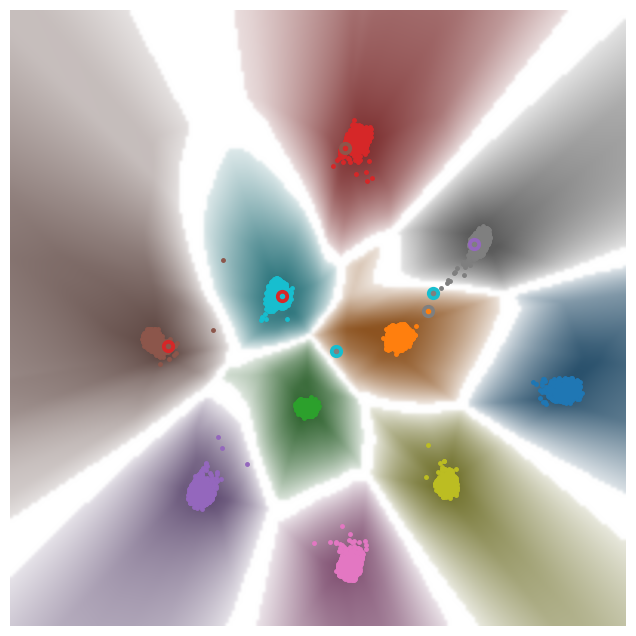

In [2]:
epoch = 20
vis.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))


In [3]:
"""get high dimensional grid, 2d grid embedding and border vector"""

grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)
train_data_embedding = projector.batch_project(epoch, data_provider.train_representation(epoch))

Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 8333.19it/s]

Successfully load the DVI visualization model for iteration 20


In [4]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 假设 train_data_embedding 和 grid_emd 都是 numpy arrays，每一行都是一个点
threshold = 20  # 设置你的阈值

# 使用 train_data_embedding 初始化 NearestNeighbors 对象
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train_data_embedding)
# 对于 grid_emd 中的每一个点，找到 train_data_embedding 中离它最近的点
distances, indices = nbrs.kneighbors(grid_emd)
# 找到距离小于阈值的索引
mask = distances.ravel() < threshold
selected_indices = np.arange(grid_emd.shape[0])[mask]

border_indices = np.arange(grid_emd.shape[0])[border==1]
union_indices = np.union1d(selected_indices, border_indices)

In [4]:
vis.show_grid_embedding(epoch=epoch, data=grid_high[[selected_indices]], embedding=grid_emd[selected_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

TypeError: show_grid_embedding() missing 1 required positional argument: 'border'

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 134/134 [00:00<00:00, 10660.18it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 134/134 [00:00<00:00, 10684.50it/s]


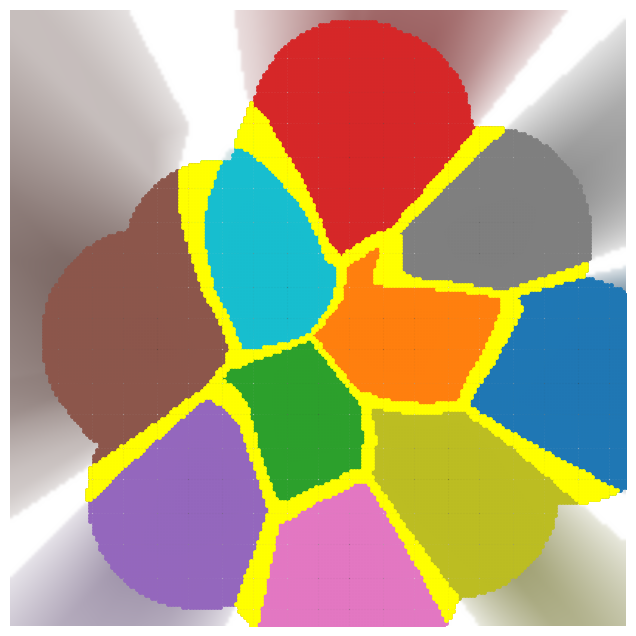

In [5]:
vis.show_grid_embedding(epoch=epoch, data=grid_high[[selected_indices]], embedding=grid_emd[selected_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
100%|██████████| 147/147 [00:00<00:00, 9986.28it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 147/147 [00:00<00:00, 9992.43it/s]


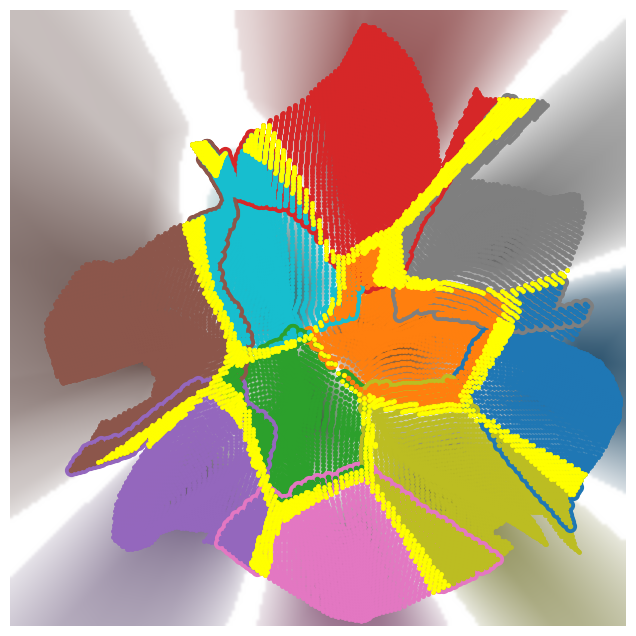

In [7]:
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[union_indices]], embedding=emb_new[union_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

In [8]:
"""Add grid into train
"""

from singleVis.SingleVisualizationModel import VisModel
from singleVis.spatial_edge_constructor import SingleEpochSpatialEdgeConstructorForGrid

pre_model = VisModel(ENCODER_DIMS, DECODER_DIMS)
file_path = os.path.join(CONTENT_PATH, "Model", "Epoch_{}".format(epoch), "{}.pth".format('dvi'))
save_model = torch.load(file_path, map_location="cpu")
pre_model.load_state_dict(save_model["state_dict"])
pre_model.to(DEVICE)


VisModel(
  (encoder): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
  )
)

In [9]:
grid_high, grid_emd ,border = vis.get_epoch_decision_view(epoch,200,None, True)

Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 200/200 [00:00<00:00, 8675.69it/s]


In [10]:
import time
optimizer = torch.optim.Adam(pre_model.parameters(), lr=.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=.1)
# Define Edge dataset
t0 = time.time()
spatial_cons = SingleEpochSpatialEdgeConstructorForGrid(data_provider, grid_high[selected_indices], epoch, S_N_EPOCHS, B_N_EPOCHS, N_NEIGHBORS)
edge_to, edge_from, probs, feature_vectors, attention = spatial_cons.construct()
t1 = time.time()
from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, TemporalLoss, DVILoss, SingleVisLoss, DummyTemporalLoss
from singleVis.edge_dataset import DVIDataHandler
from singleVis.trainer import DVITrainer
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import DataLoader
probs = probs / (probs.max()+1e-3)
eliminate_zeros = probs>5e-2    #1e-3
edge_to = edge_to[eliminate_zeros]
edge_from = edge_from[eliminate_zeros]
probs = probs[eliminate_zeros]
dataset = DVIDataHandler(edge_to, edge_from, feature_vectors, attention)

n_samples = int(np.sum(S_N_EPOCHS * probs) // 1)
# chose sampler based on the number of dataset
if len(edge_to) > pow(2,24):
    sampler = CustomWeightedRandomSampler(probs, n_samples, replacement=True)
else:
    sampler = WeightedRandomSampler(probs, n_samples, replacement=True)
edge_loader = DataLoader(dataset, batch_size=2000, sampler=sampler, num_workers=8, prefetch_factor=10)
from umap.umap_ import find_ab_params
temporal_loss_fn = DummyTemporalLoss(DEVICE)
# LAMBDA1 = 3
# Define Losses
negative_sample_rate = 5
min_dist = .1
_a, _b = find_ab_params(1.0, min_dist)
umap_loss_fn = UmapLoss(negative_sample_rate, DEVICE, _a, _b, repulsion_strength=1.0)
recon_loss_fn = ReconstructionLoss(beta=1.0)
single_loss_fn = SingleVisLoss(umap_loss_fn, recon_loss_fn, lambd=LAMBDA1)
criterion = DVILoss(umap_loss_fn, recon_loss_fn, temporal_loss_fn, lambd1=LAMBDA1, lambd2=0.0,device=DEVICE)

train_data (86786, 512)
Mon Jun 19 13:54:12 2023 Building RP forest with 20 trees
Mon Jun 19 13:54:14 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [11]:
trainer = DVITrainer(pre_model, criterion, optimizer, lr_scheduler, edge_loader=edge_loader, DEVICE=DEVICE)

t2=time.time()
trainer.train(PATIENT, MAX_EPOCH)
t3 = time.time()

    # save result
save_dir = data_provider.model_path
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "complex_construction", str(epoch), t1-t0)
trainer.record_time(save_dir, "time_{}".format(VIS_MODEL_NAME), "training", str(epoch), t3-t2)
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))
trainer.save(save_dir=save_dir, file_name="{}".format('dvi_grid'))

print("Finish epoch {}...".format(epoch))

epoch:1


100%|██████████| 2587/2587 [00:37<00:00, 69.29it/s]


umap:0.0743	recon_l:0.0207	temporal_l:0.0000	loss:0.0950
epoch:2


100%|██████████| 2587/2587 [00:36<00:00, 69.97it/s]


umap:0.0775	recon_l:0.0375	temporal_l:0.0000	loss:0.1151
epoch:3


100%|██████████| 2587/2587 [00:37<00:00, 69.72it/s]


umap:0.0726	recon_l:0.0184	temporal_l:0.0000	loss:0.0911
epoch:4


100%|██████████| 2587/2587 [00:37<00:00, 68.50it/s]


umap:0.0730	recon_l:0.0208	temporal_l:0.0000	loss:0.0938
epoch:5


100%|██████████| 2587/2587 [00:37<00:00, 69.51it/s]


umap:0.0697	recon_l:0.0045	temporal_l:0.0000	loss:0.0742
epoch:6


100%|██████████| 2587/2587 [00:40<00:00, 64.34it/s]


umap:0.0687	recon_l:0.0035	temporal_l:0.0000	loss:0.0722
epoch:7


100%|██████████| 2587/2587 [00:39<00:00, 66.28it/s]


umap:0.0682	recon_l:0.0028	temporal_l:0.0000	loss:0.0710
epoch:8


100%|██████████| 2587/2587 [00:37<00:00, 68.93it/s]


umap:0.0677	recon_l:0.0026	temporal_l:0.0000	loss:0.0703
epoch:9


100%|██████████| 2587/2587 [00:37<00:00, 68.79it/s]

umap:0.0674	recon_l:0.0024	temporal_l:0.0000	loss:0.0697
Time spend: 340.82 for training vis model...
Successfully save visualization model...
Finish epoch 20...


Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


100%|██████████| 300/300 [00:00<00:00, 6598.17it/s]


Successfully load the DVI visualization model for iteration 20


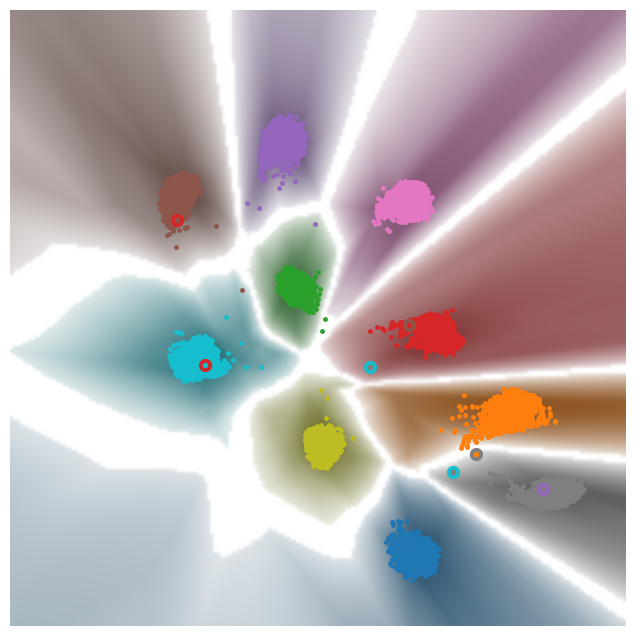

In [12]:
# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_grid', device=DEVICE)    
vis = visualizer(data_provider, projector, 200, "tab10")
vis.savefig(epoch, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20
Computing decision regions ...
Successfully load the DVI visualization model for iteration 20
Successfully load the DVI visualization model for iteration 20


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
100%|██████████| 147/147 [00:00<00:00, 9329.84it/s]


Successfully load the DVI visualization model for iteration 20


100%|██████████| 147/147 [00:00<00:00, 8036.32it/s]


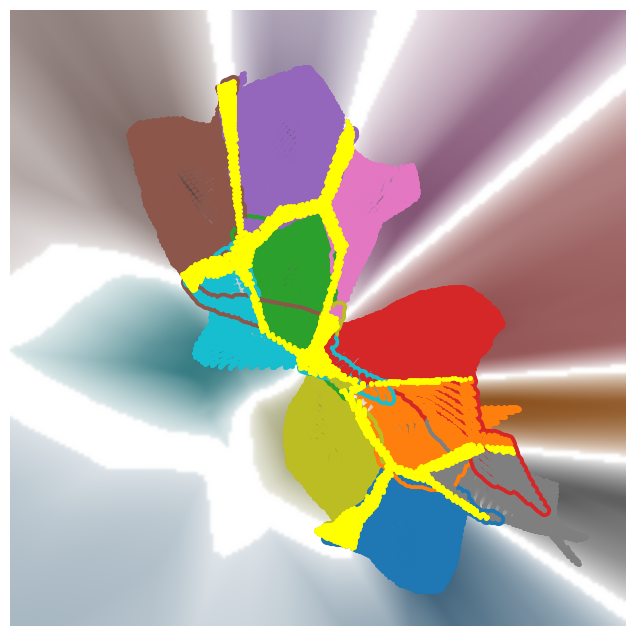

In [13]:
emb_new = projector.batch_project(epoch, grid_high)
vis.show_grid_embedding(epoch=epoch, data=grid_high[[union_indices]], embedding=emb_new[union_indices], path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))